In [1]:
import itertools
import networkx as nx
import pandas as pd
from rdflib import URIRef
from rdflib.namespace import RDF
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
from sklearn.model_selection import KFold

from cars.data import DataLoader
from cars.namespace import DASHB
from cars.recommenders.ppr import NetworkXPersonalizedPageRank
from cars.utils import visualize_graph

In [2]:
project = 'proeftuin'

In [3]:
data_loader = DataLoader(project)
graph = data_loader.get_graph()

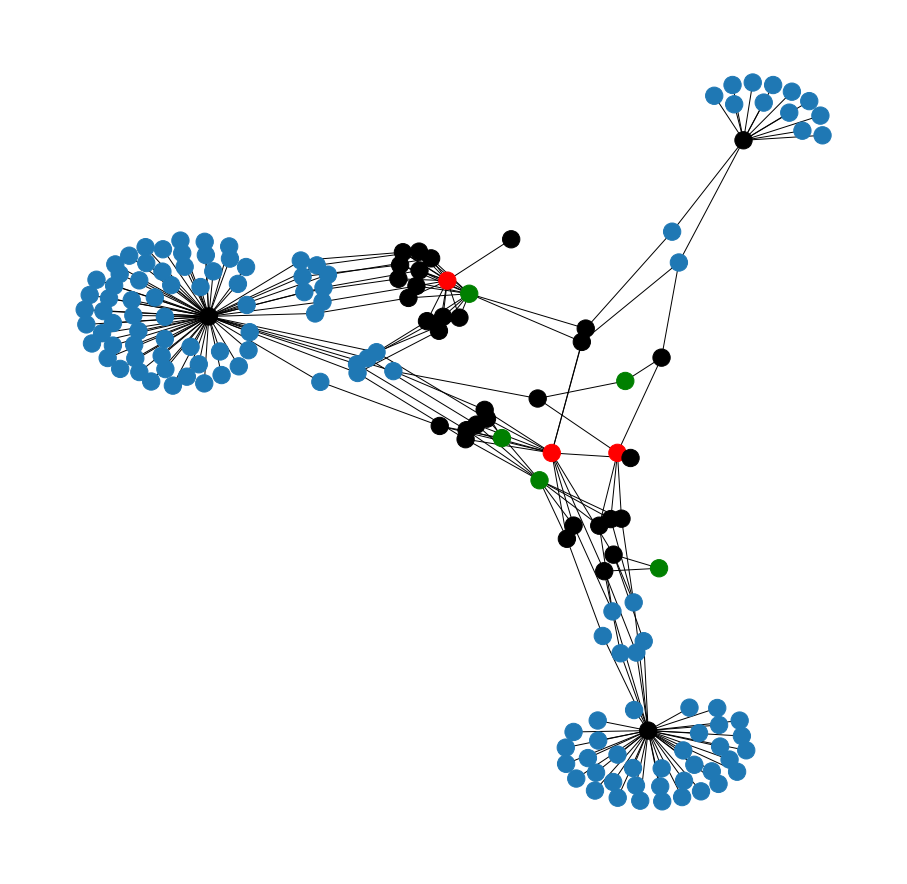

In [4]:
visualize_graph(graph, colored=True)

### PageRank

In [5]:
recommender = NetworkXPersonalizedPageRank(graph)
pr = recommender.run()

In [6]:
visualizations = list(graph.subjects(RDF.type, DASHB['Visualization']))
print(visualizations)

[rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'), rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'), rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'), rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement')]


In [7]:
pr_visualizations = dict(filter(lambda x: x[0] in visualizations, pr.items()))
print(pr_visualizations)

{rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'): 0.013878644324599072, rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement'): 0.021284219036743327, rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'): 0.004357614657664367, rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'): 0.00427494095214238, rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'): 0.004355884103813309}


In [8]:
recommendations = sorted([(item, p) for item, p in pr_visualizations.items() if item in visualizations], key=lambda n: n[1], reverse=True)

for idx, p in recommendations:
    print(f'[{p}] {idx}')

[0.021284219036743327] http://localhost/web-thing-gateway/things/visualizations/colored-measurement
[0.013878644324599072] http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector
[0.004357614657664367] http://localhost/web-thing-gateway/things/visualizations/traditional-gauge
[0.004355884103813309] http://localhost/web-thing-gateway/things/visualizations/modern-gauge
[0.00427494095214238] http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector


### Personalized PageRank

In [9]:
users = {}
for uid in graph.subjects(RDF.type, DASHB['User']):
    utype = graph.value(subject=uid, predicate=DASHB['hasRole'], any=False)
    users[uid] = utype
print(users)

{rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/13'): rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/roles/operator'), rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/12'): rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/roles/operator'), rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/15'): rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/roles/maintenance')}


In [10]:
properties = list(graph.subjects(RDF.type, DASHB['SensorProperty']))
print(properties)

[rdflib.term.URIRef('https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.kurtosis::number'), rdflib.term.URIRef('https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/rpm::number'), rdflib.term.URIRef('https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/temp.housing::number'), rdflib.term.URIRef('https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB1/metrics/pdm.HI::number'), rdflib.term.URIRef('https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB1/metrics/pdm.RUL::number'), rdflib.term.URIRef('https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB2/metrics/pdm.HI::number'), rdflib.term.URIRef('https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB2/metrics/pdm.RUL::number'), rdflib.term.URIRef('https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB3/metrics/pdm.HI::number'), rdflib.term.URIRef('https://obelisk.

In [11]:
uid = ['https://broker.dynamicdashboard.ilabt.imec.be/users/13']

cid = ['https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/rpm::number']

def get_personalization(graph, uid, cid):
    personalization = {}
    
    for node in graph.nodes:
        if node in uid:
            personalization[node] = 0.3
        elif node in cid:
            personalization[node] = 0.7
        else:
            personalization[node] = 0

    return personalization

In [12]:
pr = recommender.run(uid, cid)

recommendations = sorted([(item, p) for item, p in pr.items() if item in visualizations], key=lambda n: n[1], reverse=True)

for idx, p in recommendations:
    print(f'[{p}] {idx}')

[0.026448037700375855] http://localhost/web-thing-gateway/things/visualizations/traditional-gauge
[0.02348468206512963] http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector
[0.018018428421370216] http://localhost/web-thing-gateway/things/visualizations/modern-gauge
[0.006732564193933545] http://localhost/web-thing-gateway/things/visualizations/colored-measurement
[0.0019853630955459695] http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector


### Shortest Path

In [13]:
G = rdflib_to_networkx_multidigraph(graph).to_undirected()
nx.shortest_path(G, source=URIRef(uid[0]), target=URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'))

[rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/13'),
 rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/widgets/30'),
 rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector')]

In [14]:
for path in nx.all_shortest_paths(G, source=URIRef(uid[0]), target=URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge')):
    print(path)

[rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/13'), rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/widgets/33'), rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge')]
[rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/13'), rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/widgets/34'), rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge')]


In [15]:
nx.shortest_path(G, source=URIRef(uid[0]), target=URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'))

[rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/13'),
 rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/widgets/30'),
 rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector')]

In [16]:
nx.shortest_path(G, source=URIRef(uid[0]), target=URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement'))

[rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/13'),
 rdflib.term.URIRef('https://reasoner.dynamicdashboard.ilabt.imec.be/ontologies/dashboard#User'),
 rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/users/12'),
 rdflib.term.URIRef('https://broker.dynamicdashboard.ilabt.imec.be/widgets/27'),
 rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement')]

### Evaluation

In [17]:
qry = '''
    prefix dashb: <https://reasoner.dynamicdashboard.ilabt.imec.be/ontologies/dashboard#>

    SELECT ?user ?username ?visualization ?property WHERE {
        ?widget dashb:hasProperty ?property ;
                dashb:hasVisualization ?visualization ;
                dashb:isCreatedBy ?user .
    }
'''

result = graph.query(qry)

ratings = pd.DataFrame(columns=['user', 'item', 'rating', 'context'])

for row in result:
    user_ = row[0]
    ratings = ratings.append({'user': user_, 'item': row[2], 'rating': 5.0, 'context': row[3]},
                             ignore_index=True)
    
ratings.head()

,user,item,rating,context
0,https://broker.dynamicdashboard.ilabt.imec.be/...,http://localhost/web-thing-gateway/things/visu...,5.0,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...
1,https://broker.dynamicdashboard.ilabt.imec.be/...,http://localhost/web-thing-gateway/things/visu...,5.0,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...
2,https://broker.dynamicdashboard.ilabt.imec.be/...,http://localhost/web-thing-gateway/things/visu...,5.0,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...
3,https://broker.dynamicdashboard.ilabt.imec.be/...,http://localhost/web-thing-gateway/things/visu...,5.0,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...
4,https://broker.dynamicdashboard.ilabt.imec.be/...,http://localhost/web-thing-gateway/things/visu...,5.0,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...


In [18]:
qry = '''
    prefix dashb_v1: <http://dynamicdashboard.ilabt.imec.be/broker/ontologies/dashboard#>

    SELECT ?property ?metric WHERE {
        ?property dashb_v1:produces ?metric .
    }
'''
context_metadata = pd.DataFrame(columns=['id', 'type'])

result = graph.query(qry)
for row in result:
    context_metadata = context_metadata.append({'id': row[0], 'type': row[1]}, ignore_index=True)
    
context_metadata.head()

,id,type
0,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...,http://dynamicdashboard.ilabt.imec.be/broker/o...
1,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...,http://dynamicdashboard.ilabt.imec.be/broker/o...
2,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...,http://dynamicdashboard.ilabt.imec.be/broker/o...
3,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...,http://dynamicdashboard.ilabt.imec.be/broker/o...
4,https://obelisk.ilabt.imec.be/api/v2/scopes/sm...,http://dynamicdashboard.ilabt.imec.be/broker/o...


In [19]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(ratings)
train_idx, test_idx = list(kf.split(ratings))[0]

train = ratings.iloc[train_idx]

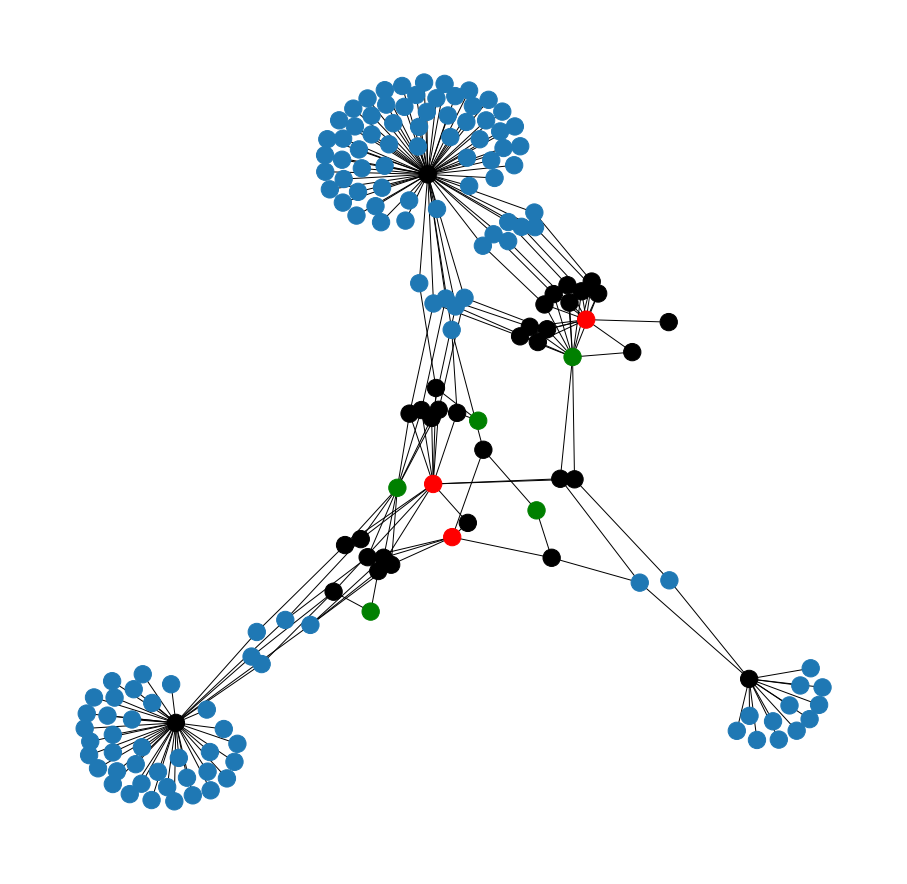

In [20]:
sub_graph = data_loader.build_subgraph_from_ratings(train)
    
visualize_graph(sub_graph, colored=True)

### Dashboard Recommendation

In [21]:
uid = ['https://broker.dynamicdashboard.ilabt.imec.be/users/13']

cid = [
    'https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/rpm::number',
    'https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFI::number',
    'https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFO::number'
]

combinations = []
for n in range(1, len(cid) + 1):
    combinations += list(itertools.combinations(cid, n))

c_pr = []
for cid_ in combinations:
    pr = recommender.predict(uid, list(cid_))
    for r in pr:
        c_pr.append({'contextId': list(cid_), 'itemId': str(r['item']), 'score': r['score']})
        
c_pr = sorted(c_pr, key=lambda r: r['score'], reverse=True)
print(c_pr)

[{'contextId': ['https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFI::number'], 'itemId': 'http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector', 'score': 0.04767125921153385}, {'contextId': ['https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFI::number', 'https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFO::number'], 'itemId': 'http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector', 'score': 0.033165679713783376}, {'contextId': ['https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/rpm::number', 'https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFI::number'], 'itemId': 'http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector', 'score': 0.032847445484670564}, {'

In [22]:
recommendations = []

cid_ = set(cid)
for i in c_pr:
    cids = set(i['contextId'])
    if cids & cid_:  # At least one item in common
        recommendations.append(i)
        cid_ -= cids

    if len(cid_) == 0:
        break
        
print(recommendations)

[{'contextId': ['https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFI::number'], 'itemId': 'http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector', 'score': 0.04767125921153385}, {'contextId': ['https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFI::number', 'https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFO::number'], 'itemId': 'http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector', 'score': 0.033165679713783376}, {'contextId': ['https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/rpm::number', 'https://obelisk.ilabt.imec.be/api/v2/scopes/smm.demos.replay/things/BBB4/metrics/acc.BPFI::number'], 'itemId': 'http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector', 'score': 0.032847445484670564}]
